## **Stance Detection**

In [0]:
!pip install tensorflow==2.0.0
! pip install vaderSentiment

In [0]:
# import the required libraries
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from tensorflow.keras.models import Model
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, make_scorer, precision_score, recall_score, accuracy_score 
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Embedding, concatenate, Conv1D, MaxPooling1D, LSTM, Bidirectional

nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")
nltk.download('stopwords')
stopword = stopwords.words('english')

In [0]:
# read the data set as a dataframe
hansard = pd.read_csv('HanDeSeT.csv')
print('Dataset Size: ', hansard.shape)
hansard.head()

Dataset Size:  (1251, 16)


,id,title,motion,manual motion,govt/opp motion,motion party affiliation,utt1,utt2,utt3,utt4,utt5,manual speech,vote speech,party affiliation,name,rebellion %
0,1,Doctor Assisted Dying,That leave be given to bring in a Bill to enab...,1,1,Lab,I trust that the House will not feel that ther...,If one considers the argument from a religious...,I accept that we shall all face death at one t...,"When we listen to my hon. Friend's case, we mu...",I do not think that we want that sort of socie...,0,0,Lab,Kevin McNamara,3.2
1,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,The Secretary State talks of the lack of fuss ...,The right hon. Gentleman may not have heard fu...,North Tayside.,The Secretary of State's geography is terrible.,Would not the £40 million gap in the assumptio...,0,0,SNP,John Swinney,0.4
2,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,May I assure the right hon. Gentleman that he ...,Will the hon. Gentleman clarify what he meant ...,NaN,NaN,NaN,1,1,Lab,John McAllion,4.5
3,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,"Is the hon. Gentleman aware that, ever since t...","I rise as one who, in the past, has not been a...",It would be inappropriate to allow the debate ...,"Why are the problems of so many of our people,...",Today's debate is the first of this sort under...,0,1,Lab,Ian Davidson,3.1
4,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,The hon. Gentleman will notice that the Childr...,I thank the hon. Gentleman for his generosity ...,NaN,NaN,NaN,1,1,Lab,Maria Fyfe,2.3


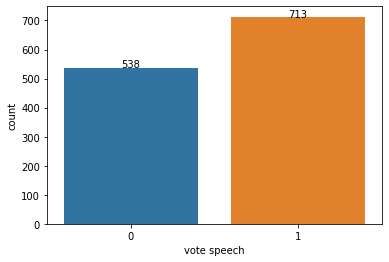

In [0]:
# Distribution of target (vote speech) variable
graph = sns.countplot(x='vote speech', data=hansard)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

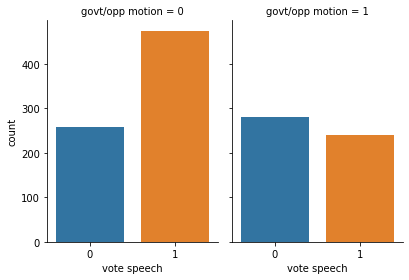

In [0]:
# Distribution of 'vote speech' (speech label) conditioned on 'govt/opp motion' (motion label)
sns.catplot(x='vote speech', col='govt/opp motion', data=hansard, kind="count", height=4, aspect=.7)

In [0]:
# Count of training examples in each of the four categories. As we can see, the dataset is imbalanced
hansard.groupby(['govt/opp motion', 'vote speech']).size()

govt/opp motion  vote speech
0                0              258
                 1              474
1                0              280
                 1              239
dtype: int64

**Pre-processing data**

Pre-processing
1. Drop unused columns - title, manual motion, manual speech, name, rebellion%
2. Combine 'utterances' columns to form a new 'speech' column
3. Remove  and proper nouns
4. Convert the text to lowercase
5. Remove punctuation, numbers, special characters
6. Remove removal_words list. We will use a manually defined list of words which contains articles, prepositions, 'months' and common words used in hansard speech like 'hon gentleman'. We are not using prefined stopwords lists from the python libraries because those lists contain words like 'not', 'dont', 'certainly' etc which are useful for stance prediction and should not be removed. Some words from the list are taken from this link and updated. https://gist.github.com/sebleier/554280
7. Convert party labels to integers

Feature creation 
(papers referred: https://www.aclweb.org/anthology/S17-2080.pdf, https://www.aclweb.org/anthology/W10-0214.pdf)
1. Find the Vader Sentiment compund score for motion and speech text
2. Count the number of question words in speech text (question words generally indicate arguments.)
3. Word Count of Speeches
3. Count number of positive and negative arguing words using arguing lexicon  #To-Do later


We calculate count of question words and arguing words only for speech text and not motion text as motions are plain sentences in the dataset.

In [0]:
def preprocess_data(df, augmented):
  '''
  Input -> df: Dataframe to be pre-processed
           augmented: boolean value which specifies if the dataframe is original or augmented. We have used data Augmentation is used to generate new text
                      Some preprocessing operations are to not be done on the augmented data frame. Thus, this argument helps to specify the condition.
  Returns -> Pre-processed DataFrame
  '''
  if not augmented:
    # Drop unused columns 
    df = df.drop(df.columns[[1, 3, 11, 14, 15]], axis=1) 

    # Combine the Utterances and create a new column named 'speech' -> easier for processing
    cols = ['utt1', 'utt2', 'utt3', 'utt4', 'utt5']
    df["speech"] = df[cols].apply(lambda x: ','.join(x.dropna()), axis=1)

    # drop utterance columns
    df = df.drop(cols, axis=1) 

    removal_words = ["a", "am", "an", "and", "any","are", "as", "at", "ae", "by", "did", "from", "he", "her", "here", \
              "hers", "herself", "him", "himself", "his", "hon", "i", "in", "into", "is", "it", "it's", "its", \
              "itself", "ll", "m", "may", "me", "my", "myself", "now", "o", "of", "on", "once", "or", "other", "our", "ours", "ourselves", \
              "re", "s", "she", "she's", "so", "st", "such", "t", "th", "that", "that'll", "the", "their", "theirs", \
              "them", "themselves", "then", "there", "these", "they", "this", "those", "to", "ve", "was", \
              "we", "were", "with", "y", "you", "youd", "youll", "will", "government", "member",\
              "you're", "you've", "your", "yours", "yourself", "yourselves", "hed", "he'll", "hes", "heres", "hows", "i'd",\
              "i'll", "im", "ive", "lets", "she'd", "she'll", "thats", "there's", "theyd", "theyll", "theyre", "theyve", "we'd",\
              "we'll", "were", "weve", "gentleman", "friend", "house", "minister", "people", "january",\
              "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "jan", "feb", "mar", \
              "apr", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

    # Since we are predicting sentiment(stance) given the motion statement, it is essential to include features from the motion text to identify whether the motion is positive or negative.
    # We will clean both motion and speech text
    # Motion text contains numbers and some extra information in brackets which is just plain text and does not express any emotion. So the bracketed text and numbers will be removed
    df['cleaned_motion'] = df['motion'].apply(lambda x: ' '.join([word for word, tag in pos_tag(x.split()) if tag != 'NNP' or tag != 'NNPS']))
    df['cleaned_motion'] = df['cleaned_motion'].str.lower()
    df['cleaned_motion'] = df['cleaned_motion'].str.replace("\(.*\)", "")
    df['cleaned_motion'] = df['cleaned_motion'].str.replace("[^a-zA-Z ]", "") 
    df['cleaned_motion'] = df['cleaned_motion'].apply(lambda x: ' '.join([word for word in x.split() if (word not in removal_words) and len(word)>1]))

    # Cleaning speech text
    df['cleaned_speech'] = df['speech'].apply(lambda x: ' '.join([word for word, tag in pos_tag(x.split()) if tag != 'NNP' or tag != 'NNPS']))
    df['cleaned_speech'] = df['cleaned_speech'].str.lower()
    df['cleaned_speech'] = df['cleaned_speech'].str.replace("[^a-zA-Z ]", "") 
    df['cleaned_speech'] = df['cleaned_speech'].apply(lambda x: ' '.join([word for word in x.split() if (word not in removal_words) and len(word)>1]))

    # drop speech and motion columns
    df = df.drop(['motion', 'speech'], axis=1) 

    # Let us convert the party labels to integer 
    motion_party = {'Lab': 1, 'Con': 2, 'SNP': 3, 'DUP': 4, 'LD':5}
    party = {'Lab': 1, 'Con': 2, 'SNP': 3, 'DUP': 4, 'LD':5, 'SDLP': 6, 'IndUU': 6, 'UUP': 6, 'IndSN': 6, 'Green': 6, 'PC': 6, 'IndCon': 6, 'IndLab': 6}

    df['motion party affiliation'] = df['motion party affiliation'].apply(lambda x: motion_party[x])
    df['party affiliation'] = df['party affiliation'].apply(lambda x: party[x])

  # New feature creation
  # 1. question word count
  df['speech_ques_words'] = df['cleaned_speech'].str.count(r'(what)|(when)|(where)|(which)|(who)|(whom)|(why)|(whose)|(how)')

  # 2. vader sentiment compund score
  analyser = SentimentIntensityAnalyzer()
  df['motion_score'] = df['cleaned_motion'].apply(lambda x: (analyser.polarity_scores(x))['compound'])
  df['speech_score'] = df['cleaned_speech'].apply(lambda x: (analyser.polarity_scores(x))['compound'])

  # 3. speech word count
  df['speech_word_count'] = df['cleaned_speech'].apply(lambda x: len([w for w in x.split()]))

  return df

hansard = preprocess_data(hansard, False)
hansard.head()
  

,id,govt/opp motion,motion party affiliation,vote speech,party affiliation,cleaned_motion,cleaned_speech,speech_ques_words,motion_score,speech_score,speech_word_count
0,1,1,1,0,1,leave be given bring bill enable person who su...,trust not feel lack compassion side argument a...,14,-0.8555,-0.9983,353
1,2,1,1,0,3,local finance order dated copy which laid befo...,secretary state talks lack fuss about local se...,4,0.4215,0.5859,116
2,2,1,1,1,1,local finance order dated copy which laid befo...,assure right probably alone thinking sad matte...,4,0.4215,-0.7269,59
3,2,1,1,1,1,local finance order dated copy which laid befo...,aware ever since beginning urban aid programme...,10,0.4215,0.9781,289
4,2,1,1,1,1,local finance order dated copy which laid befo...,notice children scotland act enacted has been ...,2,0.4215,0.6748,111


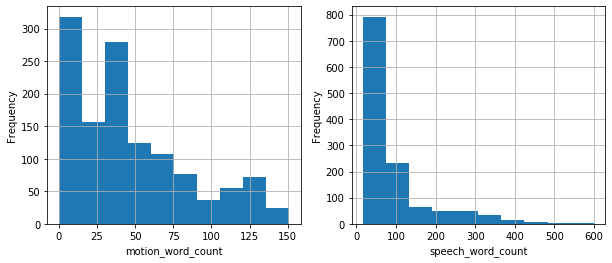

In [0]:
# Distribution of word counts in motion and speech text after preprocessing
motion_word_count = hansard['cleaned_motion'].apply(lambda x: len([w for w in x.split()]))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
motion_word_count.hist(ax=axes[0])
hansard['speech_word_count'].hist(ax=axes[1])
x_labels = ['motion_word_count', 'speech_word_count']
i = 0
for ax in axes:
  ax.yaxis.grid(True)
  ax.set_xlabel(x_labels[i])
  ax.set_ylabel('Frequency')
  i = i + 1

# **Classification Models and Feature selection**
We will build the following models
1. Support Vector Machines
2. Neural Netowrks

We will analyze the prediction accuracy of models 
1. Text data will be converted to following representations - token combination of 1,2,3 grams
   1. Bag of Words (SVMs)
   2. TF-IDF (SVMs, Neural Networks)
   3. Glove (Neural Networks)

2. Extra available features along with Speech column. 
   The features are (References: https://www.aclweb.org/anthology/L18-1659.pdf)
   1. Debate id -> . As there are usually multiple speeches in each debate, and MPs will often express similar sentiments to members of their own party in a particular debate, we also follow Salah (2014) in including this feature to capture possible correlations between MPs’ speech and voting behaviour.
   2. Speaker party affiliation -> Intuition suggests
that a speaker’s party membership should be
a strong indicator of sentiment towards many
topics, and Salah (2014) showed this to be the
case, at least as far as correlation with speakers’ division votes goes
   3. Motion party affiliation. Because MPs are
likely to be more or less supportive of a motion depending on who proposes it, we add that Member’s party as a further contextual feature.
   4. Govt/Oppo Motion 

3. Newly created features
  1. Vader sentiment score
  2. Count of question words
  3. Count of words in speech text
 

   Papers and websites referred for neural networks implemetation
1. https://www.aclweb.org/anthology/L18-1659.pdf
2. https://arxiv.org/pdf/1510.03820.pdf
3. https://www.aclweb.org/anthology/W10-0214.pdf
4. 
5. https://machinelearningmastery.com
6. http://www.davidsbatista.net/blog/2018/03/31/SentenceClassificationConvNets/
    

Let us draw WordClouds and find the frequest words in positive and negative speeches

In [0]:
# Method to generate word clouds
def create_wordcloud(label):
  # combine all the tweets and build a wordCloud for 'Labour' party
  text = ' '.join([sent for sent in hansard['cleaned_speech'][hansard['vote speech'] == label]])
  wordcloud = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(text)
  plt.figure(figsize=(10, 7)) 
  plt.imshow(wordcloud, interpolation="bilinear") 
  plt.axis('off')


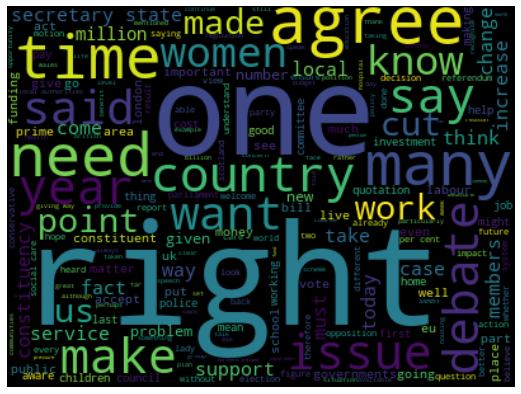

In [0]:
create_wordcloud(1)

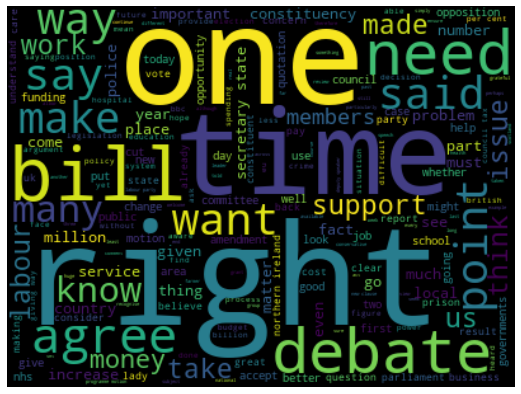

In [0]:
create_wordcloud(0)

As we can see, we cannot infer about positive or negative speeches from the words clouds because both use similar set of frequent words. 
Now, we will split the data into 90% train and 10% test set

In [0]:
x_train, x_test, y_train, y_test = train_test_split(hansard, hansard['vote speech'], test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1125, 11)
(1125,)
(126, 11)
(126,)


Let's create Bag Of Words and TF-IDF features

In [0]:
# Method to create a new matrix with added features
def add_feature(X, Y, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    return hstack([X, Y, csr_matrix(feature_to_add).T], 'csr')

# Method to convert text using CountVectorizer
def generate_bow_val(x_train, x_test):
  bow_vectorizer_motion = CountVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
  bow_vectorizer_speech = CountVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3)) 
  bow_motion = bow_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
  bow_motion_test = bow_vectorizer_motion.transform(x_test['cleaned_motion'])
  bow_speech = bow_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
  bow_speech_test = bow_vectorizer_speech.transform(x_test['cleaned_speech'])
  return bow_motion, bow_motion_test, bow_speech, bow_speech_test

# Method to convert text using TfidfVectorizer
def generate_tfidf_val(x_train, x_test):
  tfidf_vectorizer_motion = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
  tfidf_vectorizer_speech = TfidfVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3)) 
  tfidf_motion = tfidf_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
  tfidf_motion_test = tfidf_vectorizer_motion.transform(x_test['cleaned_motion'])
  tfidf_speech = tfidf_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
  tfidf_speech_test = tfidf_vectorizer_speech.transform(x_test['cleaned_speech'])
  return tfidf_motion, tfidf_motion_test, tfidf_speech, tfidf_speech_test

# Method to generate ROC-AUC Curve
def plot_roc_curve(fpr, tpr):
  lw = 2
  area = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % area)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

# Below methods are used to fit Support Vector Classifiers and perform cross-validation
# Method instantiates a SVC on training data and performs cross-validation to find the best regularization parameter
def find_best_reg(inverse_lambda, train_data, train_labels):
  mean_scores = []
  for reg in inverse_lambda:
    svm = SVC(C=reg, gamma='scale')
    all_scores = cross_val_score(svm, train_data, train_labels, cv=5, scoring='f1')
    mean_scores.append(all_scores.mean())
  return mean_scores

# Method uses the best parameter 'C' to predict labels on test data
def svm_predict(reg, train_data, train_labels, test_data):
  final_svm = SVC(C=reg, gamma='scale')
  final_svm.fit(train_data, train_labels)
  y_pred_svm = final_svm.predict(test_data)
  return y_pred_svm

In [0]:
bow_motion, bow_motion_test, bow_speech, bow_speech_test = generate_bow_val(x_train, x_test)
tfidf_motion, tfidf_motion_test, tfidf_speech, tfidf_speech_test = generate_tfidf_val(x_train, x_test)

# Create the final feature matrix by adding extra features
bow = add_feature(bow_motion, bow_speech, [x_train['id'], x_train['motion party affiliation'], x_train['govt/opp motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
bow_test = add_feature(bow_motion_test, bow_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['govt/opp motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
tfidf = add_feature(tfidf_motion, tfidf_speech, [x_train['id'], x_train['motion party affiliation'], x_train['govt/opp motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
tfidf_test = add_feature(tfidf_motion_test, tfidf_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['govt/opp motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'],  x_test['speech_word_count']])

print('BOW train matrix shape: ', bow.shape)
print('BOW test matrix shape: ', bow_test.shape)
print('TF-IDF train matrix shape: ', tfidf.shape)
print('TF-IDF test matrix shape: ', tfidf_test.shape)

BOW train matrix shape:  (1125, 13686)
BOW test matrix shape:  (126, 13686)
TF-IDF train matrix shape:  (1125, 13686)
TF-IDF test matrix shape:  (126, 13686)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
**Support Vector Machines using BOW and TF-IDF features for Text**<br/>
We are using cross-validation to find the best regularization value.

*Support Vector Classifier using BOW features*

Mean Scores:  [0.7331065041937015, 0.7331065041937015, 0.7331065041937015, 0.7086706494730846, 0.7539723851462878, 0.7438795553937683, 0.7412830049557412, 0.741047010028735, 0.7398408360883482, 0.736997192041723, 0.7371365906046773, 0.7311690676035456, 0.7198130452226181, 0.7214841412034103, 0.7208949660414125]


Text(0, 0.5, 'Mean Scores')

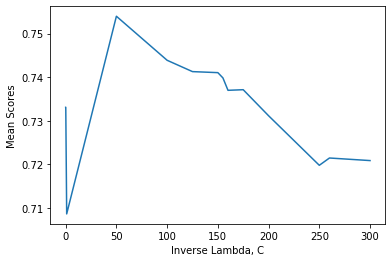

In [0]:
# Cross validate the model using a set of 'C' values
inverse_lambda = [0.001, 0.01, 0.1, 1, 50, 100, 125, 150, 155, 160, 175, 200, 250, 260, 300]
mean_scores = find_best_reg(inverse_lambda, bow, y_train)
print('Mean Scores: ', mean_scores)
plt.plot(inverse_lambda, mean_scores)
plt.xlabel('Inverse Lambda, C')
plt.ylabel('Mean Scores')

Confusion Matrix:
 [[29 35]
 [11 51]]
F1-score:  0.6891891891891893
ROC_AUC_score:  0.6378528225806452


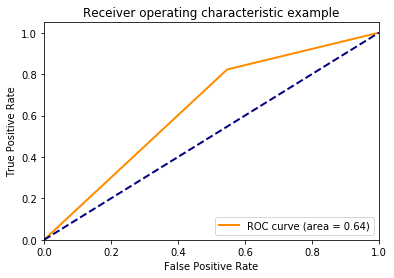

In [0]:
# Refit the model using the best 'C' (highest mean score)
y_pred_svm = svm_predict(50, bow, y_train, bow_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('F1-score: ', f1_score(y_test, y_pred_svm))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plot_roc_curve(fpr, tpr)

--------------------------------------------------------------------------------
*Support Vector Classifier using TF-IDF features*

Mean Scores:  [0.7500863950461731, 0.7506354143059912, 0.751820543746895, 0.7593442894966547, 0.7638603044721626, 0.7672265002157536, 0.7640890757960509, 0.7657217124876198, 0.766988145436485, 0.772650747340849, 0.7717861773413648, 0.7717347525625231]


Text(0, 0.5, 'Mean Scores')

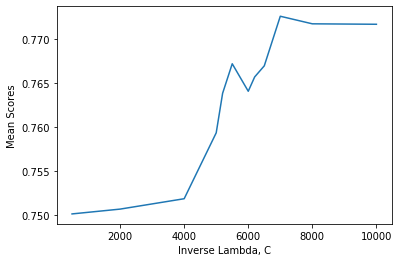

In [0]:
inverse_lambda = [500, 2000, 4000, 5000, 5200, 5500, 6000, 6200, 6500, 7000, 8000, 10000]
mean_scores = find_best_reg(inverse_lambda, tfidf, y_train)
print('Mean Scores: ', mean_scores)
plt.plot(inverse_lambda, mean_scores)
plt.xlabel('Inverse Lambda, C')
plt.ylabel('Mean Scores')

Confusion Matrix:
 [[37 27]
 [12 50]]
F1-score:  0.7194244604316546
ROC_AUC_score:  0.692288306451613


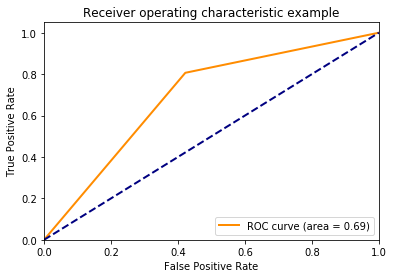

In [0]:
y_pred_svm = svm_predict(7000, tfidf, y_train, tfidf_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('F1-score: ', f1_score(y_test, y_pred_svm))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plot_roc_curve(fpr, tpr)

In [0]:
del bow, bow_motion, bow_speech, bow_speech_test, bow_test, bow_motion_test
del tfidf_motion, tfidf_speech, tfidf_motion_test, tfidf_speech_test

---------------------------------------------------------------------------------------------------------------------------------------------------------------<br/>**1. Single Channel Fully Connected Neural Network**<br/> 
Let us build a simple simple MLP model to predict the stance. We use the tfidf text feature matrix along with the other feature columns. We use Grid Search to find the right number of hidden neurons which give the best AUC. We check the AUC as the metric since we hava an imbalanced dataset. 

In [0]:
# First neural network model with one hidden layer and Dropout/Batchnormalization
def nn_model_1(num_neurons, initial_bias):
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(num_neurons, activation='relu',  kernel_initializer='he_normal'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(num_neurons, activation='relu', kernel_initializer='he_normal'),        
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)  
  return model

In [0]:
model_CV = KerasClassifier(build_fn=nn_model_1, epochs=200, batch_size=250, verbose=0)
# define the grid search parameters

num_neurons = [50, 75, 100, 120, 150, 200, 250]

scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'auc':make_scorer(roc_auc_score)
}
initial_bias = math.log(2)
param_grid = dict(num_neurons=num_neurons, initial_bias=initial_bias)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=4, refit='auc' , scoring = scores)
grid_result = grid.fit(tfidf.toarray(), y_train, verbose=0)


In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_auc']
stds = grid_result.cv_results_['std_test_auc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.668929 using {'num_neurons': 120}
0.653625 (0.033397) with: {'num_neurons': 50}
0.655821 (0.059245) with: {'num_neurons': 75}
0.652153 (0.026744) with: {'num_neurons': 100}
0.668929 (0.019468) with: {'num_neurons': 120}
0.648873 (0.043245) with: {'num_neurons': 150}
0.661186 (0.035621) with: {'num_neurons': 200}
0.658813 (0.011195) with: {'num_neurons': 250}


Confusion Matrix:
 [[42 22]
 [22 40]]
F1-score:  0.6451612903225806
ROC_AUC_score:  0.6507056451612903


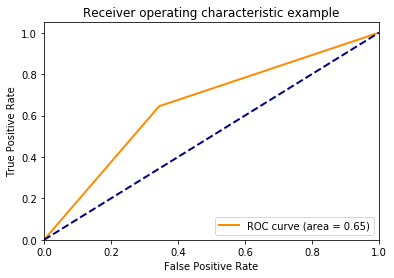

In [0]:
y_pred = grid_result.predict(tfidf_test.toarray())
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr)

--------------------------------------------------------------------------------
**2. Multi-Channel Neual Network with LSTM**<br/>
The NN consists of two channels. 
1. The first channel takes motion and speech text as input and uses a Bidirectional LSTM to learn weights
2. The third channel takes the additional features and uses a fully connected dense layer to learn weights

In [0]:
# Prepare the data to feed to the network
def reshape_data_lstm(x_train, x_test, y_test, tfidf_motion, tfidf_speech):
  xtrain = hstack([tfidf_motion, tfidf_speech], 'csr')
  xtest = hstack([tfidf_motion_test, tfidf_speech_test], 'csr')

  xtrain, xval, ytrain, yval = train_test_split(xtrain, x_train['vote speech'], test_size=0.1, random_state=42)
  ytrain = np.array(ytrain)
  ytest = np.array(y_test)
  yval = np.array(yval)

  xtrain2 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['govt/opp motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
  xtrain2, xval2, _, _ = train_test_split(xtrain2, x_train['vote speech'], test_size=0.1, random_state=42)
  xtest2 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['govt/opp motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])

  # reshape data to feed into LSTM
  xtrain = xtrain.toarray()
  xval = xval.toarray()
  xtest = xtest.toarray()
  xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])
  xval = xval.reshape(xval.shape[0], 1, xval.shape[1])
  xtest = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])
  ytrain = ytrain.reshape(ytrain.shape[0], 1)
  yval = yval.reshape(yval.shape[0], 1)
  ytest = ytest.reshape(ytest.shape[0], 1)

  return xtrain, xval, xtest, xtrain2, xval2, xtest2, ytrain, yval, ytest

# Mutli-channel nn model
def nn_model_2(n_neurons, length2, metrics):
  # channel 1
  inputs1 = Input(shape=(1, xtrain.shape[2]))
  lstm1 = LSTM(20, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(inputs1)
  drop1 = Dropout(rate=0.5)(lstm1)
  flat1 = Flatten()(drop1)
  dense1 = Dense(16, activation='relu', kernel_initializer="he_normal")(flat1)

  # channel 2
  inputs2 = Input(shape=(length2,))
  dense2 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs2)
  drop2 = Dropout(rate=0.7)(dense2)
  bn2 = BatchNormalization()(drop2)

  # merge
  merged = concatenate([dense1, bn2])

  # shared
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop3 = Dropout(rate=0.5)(dense3)
  bn3 = BatchNormalization()(drop3)
  outputs = Dense(1, activation='sigmoid')(bn3)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model

# Plots the graphs of different metrics vs epochs
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = (12, 10)
def plot_metrics(history):
  metrics =  ['loss', 'accuracy','auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

In [0]:
xtrain, xval, xtest, xtrain2, xval2, xtest2, ytrain, yval, ytest = reshape_data_lstm(x_train, x_test, y_test, tfidf_motion, tfidf_speech)

print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)
print(xtest.shape)
print(ytest.shape)

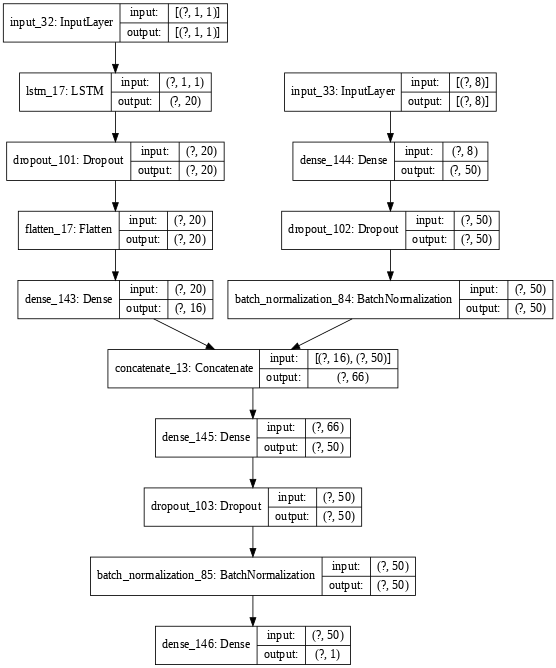

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model1.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='min')
model = nn_model_2(50, xtrain2.shape[1], metrics)
plot_model(model, to_file='model1.png', show_shapes=True, dpi=60)

In [0]:
history = model.fit([xtrain, xtrain2.toarray()], ytrain, epochs=50, batch_size=300, validation_data=([xval, xval2.toarray()], yval), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 1012 samples, validate on 113 samples
Epoch 1/50
1012/1012 [==============================] - 3s 3ms/sample - loss: 0.8506 - accuracy: 0.5059 - precision: 0.5840 - recall: 0.5102 - auc: 0.5146 - val_loss: 0.9095 - val_accuracy: 0.4159 - val_precision: 0.4815 - val_recall: 0.2000 - val_auc: 0.4359
Epoch 2/50
1012/1012 [==============================] - 0s 384us/sample - loss: 0.8759 - accuracy: 0.4842 - precision: 0.5640 - recall: 0.4812 - auc: 0.4939 - val_loss: 0.7882 - val_accuracy: 0.4425 - val_precision: 0.5357 - val_recall: 0.2308 - val_auc: 0.4556
Epoch 3/50
1012/1012 [==============================] - 0s 359us/sample - loss: 0.8611 - accuracy: 0.4842 - precision: 0.5606 - recall: 0.5051 - auc: 0.4804 - val_loss: 0.7428 - val_accuracy: 0.4779 - val_precision: 0.5750 - val_recall: 0.3538 - val_auc: 0.4800
Epoch 4/50
1012/1012 [==============================] - 0s 387us/sample - loss: 0.8150 - accuracy: 0.5198 - precision: 0.5926 - recall: 0.5461 - auc: 0.5203 - val_loss: 

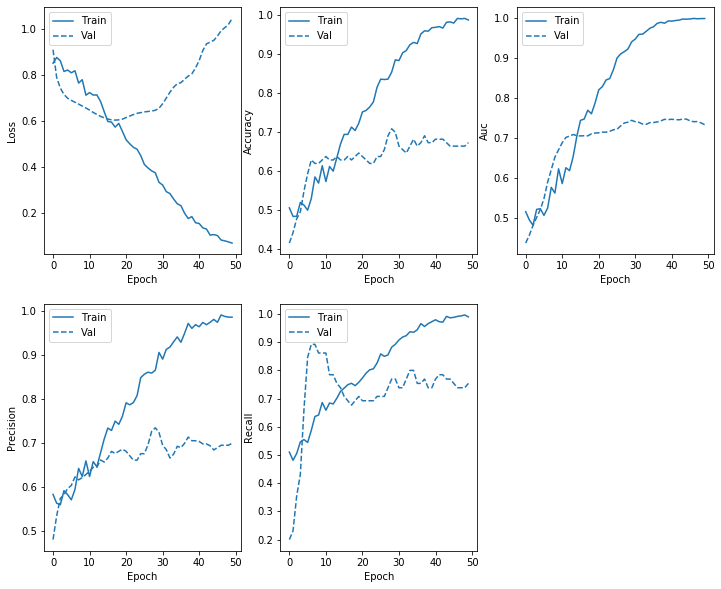

In [0]:
plot_metrics(history)

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model1.hdf5")
results = model.evaluate([xtest, xtest2.toarray()], ytest, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.6846347545820569
accuracy :  0.61904764
precision :  0.6
recall :  0.67741936
auc :  0.7009829



----------------------------------------------------------------------------------------------------------------------------------------------------------------
**3. Glove Embeddingds + LSTM**

In [0]:
x_old = x_train
x_train, x_val, y_train, y_val = train_test_split(x_train, x_train['vote speech'], test_size=0.1)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1012, 11)
(1012,)
(126, 11)
(126,)


In [0]:
# Preparing text for Embedding layer
def create_embedding_text(tokenizer, train, val, test, max_length):
  if max_length is None:
    max_length = max([len(sent.split()) for sent in train])
  train_sequences = tokenizer.texts_to_sequences(train)
  train_padded = pad_sequences(train_sequences, padding='pre', maxlen=max_length, truncating='pre')
  validation_sequences = tokenizer.texts_to_sequences(val)
  validation_padded = pad_sequences(validation_sequences, padding='pre', maxlen=max_length, truncating='pre')
  test_sequences = tokenizer.texts_to_sequences(test)
  test_padded = pad_sequences(test_sequences, padding='pre', maxlen=max_length, truncating='pre')
  return (train_padded, validation_padded, test_padded, max_length)

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_old['cleaned_motion'] + x_old['cleaned_speech'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

Xtrain1, Xval1, Xtest1, length1 = create_embedding_text(tokenizer, x_train['cleaned_motion'], x_val['cleaned_motion'], x_test['cleaned_motion'], None)
Xtrain2, Xval2, Xtest2, length2 = create_embedding_text(tokenizer, x_train['cleaned_speech'], x_val['cleaned_speech'], x_test['cleaned_speech'], 400)
Xtrain3 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['govt/opp motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
Xval3 = add_feature(None, None, [x_val['id'], x_val['motion party affiliation'], x_val['party affiliation'], x_val['govt/opp motion'], x_val['speech_ques_words'], x_val['motion_score'], x_val['speech_score'], x_val['speech_word_count']])
Xtest3 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['govt/opp motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
length3 = Xtrain3.shape[1]



In [0]:
# load the Glove embeddings
EMBEDDING_DIM = 100
embeddings_index = {}
f = open(r'glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-100])
    print(word)
    coefs = np.array(values[-100:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [0]:
# Create the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_motion = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=length1,
                            trainable=False)


embedding_speech = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=length2,
                            trainable=False)



In [0]:
def nn_model_4(n_neurons, length1, length2, length3, metrics):
  # channel 1
  inputs1 = Input(shape=(length1,))
  embedding1 = embedding_motion(inputs1)
  lstm1 = LSTM(32, recurrent_dropout=0.7)(embedding1)
  drop1 = Dropout(rate=0.5)(lstm1)
  flat1 = Flatten()(drop1)
  dense1 = Dense(1, activation='relu')(flat1)

  # channel 2
  inputs2 = Input(shape=(length2,))
  embedding2 = embedding_speech(inputs2)
  lstm2 = LSTM(75, recurrent_dropout=0.7)(embedding2)
  drop2 = Dropout(rate=0.5)(lstm2)
  flat2 = Flatten()(drop2)
  dense2 = Dense(1, activation='relu')(flat2)

  # channel 3 
  inputs3 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs3)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge
  merged = concatenate([dense1, dense2, bn3])

  # shared
  dense4 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop4 = Dropout(rate=0.5)(dense4)
  bn4 = BatchNormalization()(drop4)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model



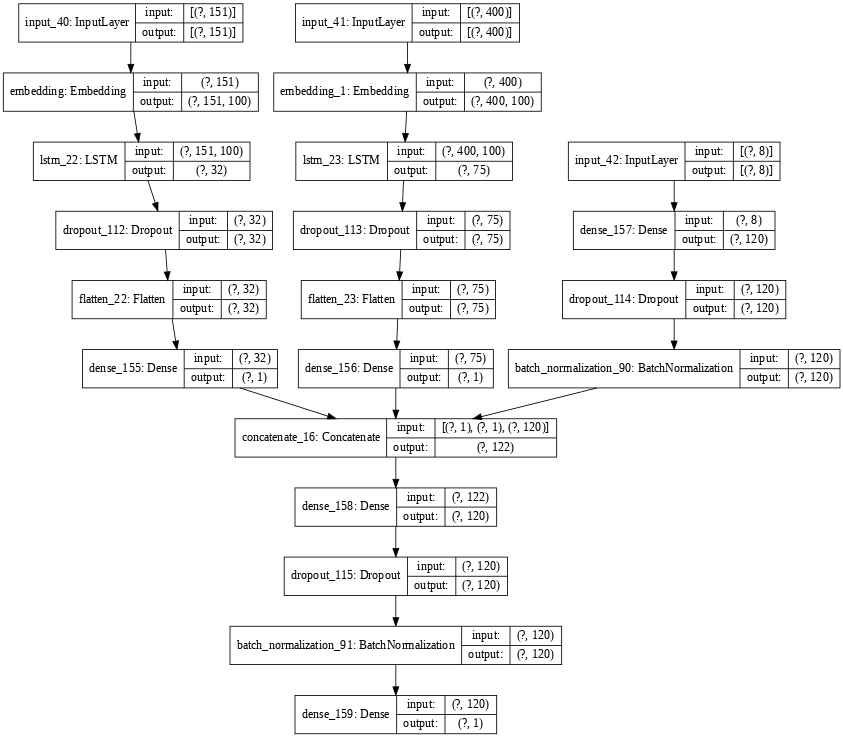

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = nn_model_4(120, length1, length2, length3, metrics)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model2.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
plot_model(model, to_file='model2.png', show_shapes=True, dpi=60)

In [0]:
history = model.fit([Xtrain1, Xtrain2, Xtrain3.toarray()], y_train, epochs=100, batch_size=400, validation_data=([Xval1, Xval2, Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

Train on 1012 samples, validate on 113 samples
Epoch 1/100
1012/1012 [==============================] - 9s 9ms/sample - loss: 0.8635 - accuracy: 0.4970 - precision: 0.5790 - recall: 0.5135 - auc: 0.4852 - val_loss: 1.1689 - val_accuracy: 0.5221 - val_precision: 0.5221 - val_recall: 1.0000 - val_auc: 0.5623
Epoch 2/100
1012/1012 [==============================] - 4s 4ms/sample - loss: 0.8645 - accuracy: 0.5040 - precision: 0.5840 - recall: 0.5287 - auc: 0.5015 - val_loss: 0.9685 - val_accuracy: 0.5221 - val_precision: 0.5221 - val_recall: 1.0000 - val_auc: 0.5840
Epoch 3/100
1012/1012 [==============================] - 4s 4ms/sample - loss: 0.8194 - accuracy: 0.5385 - precision: 0.6122 - recall: 0.5760 - auc: 0.5403 - val_loss: 0.8694 - val_accuracy: 0.5398 - val_precision: 0.5321 - val_recall: 0.9831 - val_auc: 0.5863
Epoch 4/100
1012/1012 [==============================] - 4s 4ms/sample - loss: 0.8244 - accuracy: 0.5524 - precision: 0.6205 - recall: 0.6047 - auc: 0.5487 - val_loss: 0.

In [0]:
plot_metrics(history)

NameError: ignored

In [0]:
# Evaluate the accuracy of the best model on test set
model.load_weights("best_model2.hdf5")
results = model.evaluate([Xtest1, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.6527251232238043
accuracy :  0.6825397
precision :  0.66
recall :  0.9166667
auc :  0.7362397



--------------------------------------------------------------------------------********************************************************************************--------------------------------------------------------------------------------<br/>
**Data Augmentation**<br/>
Referred: https://www.kaggle.com/theoviel/using-word-embeddings-for-data-augmentation<br/>
The notebook uses word embeddings and sklearn's nearest neighbours method to replace most frequent words with synonyms and thus generate new examples.<br/>

In [0]:
# Number of training examples in each of the four categories
hansard.groupby(['govt/opp motion', 'vote speech']).size()

govt/opp motion  vote speech
0                0              258
                 1              474
1                0              280
                 1              239
dtype: int64

As we can see, there are almost double the count of training examples with negative motion(label=0) and speech in favour of the motion(label=1). Thus we will try to generate more examples for the other categories.<br/>
We will remove stopwords from the text (motion + speech) and all words of length <=4 -> fit a new tokenizer -> create an embedding matrix

In [0]:
# remove stopwords and words with length < 3
text = hansard['cleaned_motion'] + hansard['cleaned_speech']
cleaned_text = text.apply(lambda x: ' '.join([word for word in x.split() if (word not in stopword) and len(word)>=5]))

# Fit tokenizer and pad sequences
tokenizer2 = Tokenizer(num_words=1000)
tokenizer2.fit_on_texts(cleaned_text)
word_index2 = tokenizer2.word_index
motion_seq = tokenizer2.texts_to_sequences(hansard['cleaned_motion'])
speech_seq = tokenizer2.texts_to_sequences(hansard['cleaned_speech'])
padded_motion = pad_sequences(motion_seq, 150)
padded_speech = pad_sequences(speech_seq, 400)

# create a embedding matrix for the words 
embed_mat_syn = np.zeros((len(word_index2) + 1, 100))
for word, i in word_index2.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embed_mat_syn[i] = embedding_vector



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from sklearn.neighbors import NearestNeighbors

index_word = {0: ''}
for word in tokenizer2.word_index.keys():
    index_word[tokenizer2.word_index[word]] = word

synonyms_number = 5
word_number = 1000

nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat_syn) 
# Find synonyms for words
neighbours_mat = nn.kneighbors(embed_mat_syn[1:word_number+1])[1]
synonyms = {x[0]: x[1:] for x in neighbours_mat}
# Print synonyms
for x in np.random.randint(1, word_number, 10):
    print(f"{index_word[x]} : {[index_word[synonyms[x][i]] for i in range(synonyms_number-1)]}")

similar : ['unusual', 'example', 'unlike', 'although']
decent : ['respectable', 'terrific', 'excellent', 'perfect']
central : ['eastern', 'western', 'southeast', 'northern']
cannabis : ['ecstasy', 'cocaine', 'heroin', 'alcohol']
listened : ['listen', 'listening', 'talked', 'reminded']
changed : ['changing', 'though', 'although', 'latter']
framework : ['implementation', 'implementing', 'frameworks', 'principles']
speaker : ['outgoing', 'parliament', 'speakers', 'assembly']
efforts : ['effort', 'progress', 'continuing', 'hoped']
south : ['north', 'western', 'southeast', 'southern']


In [0]:
def modify_sentence(sentence, synonyms, p=0.5):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

# We are generating 250 new sentences
def generate_sent(motion_data, speech_data):
  indexes = np.random.randint(0, motion_data.shape[0], 250)
  motions = []
  speeches = []
  for x in motion_data[indexes]:   
      sample =  np.trim_zeros(x)
      #sentence = ' '.join([index_word[i] for i in sample])
      modified = modify_sentence(sample, synonyms)
      sentence_m = ' '.join([index_word[x] for x in modified])
      motions.append(sentence_m)

  for x in speech_data[indexes]:   
      sample =  np.trim_zeros(x)
      #sentence = ' '.join([index_word[i] for i in sample])
      modified = modify_sentence(sample, synonyms)
      sentence_m = ' '.join([index_word[x] for x in modified])
      speeches.append(sentence_m)
  return motions, speeches, indexes

def augment_data(motion_data, speech_data, df):
  motions, speeches, indexes = generate_sent(motion_data, speech_data)
  df = df.iloc[indexes]
  df['cleaned_motion'] = pd.Series(motions)
  df['cleaned_speech'] = pd.Series(speeches)
  return df


In [0]:
# Generate data for three categories with less number of data points (< 300)
true_values = (hansard['govt/opp motion']==0) & (hansard['vote speech']==0)
motion_data = padded_motion[true_values]
speech_data = padded_speech[true_values]
df1 = hansard.loc[true_values, ['id', 'govt/opp motion',	'motion party affiliation',	'vote speech',	'party affiliation']]
df1.reset_index(drop=True, inplace=True)
df1 = augment_data(motion_data, speech_data, df1).dropna()

true_values = (hansard['govt/opp motion']==1) & (hansard['vote speech']==0)
motion_data = padded_motion[true_values]
speech_data = padded_speech[true_values]
df2 = hansard.loc[true_values, ['id', 'govt/opp motion',	'motion party affiliation',	'vote speech',	'party affiliation']]
df2.reset_index(drop=True, inplace=True)
df2 = augment_data(motion_data, speech_data, df2).dropna()

true_values = (hansard['govt/opp motion']==1) & (hansard['vote speech']==1)
motion_data = padded_motion[true_values]
speech_data = padded_speech[true_values]
df3 = hansard.loc[true_values, ['id', 'govt/opp motion',	'motion party affiliation',	'vote speech',	'party affiliation']]
df3.reset_index(drop=True, inplace=True)
df3 = augment_data(motion_data, speech_data, df3).dropna()

df = pd.concat([df1, df2, df3])
df = preprocess_data(df, True)
hansard = pd.concat([hansard, df]).reset_index(drop=True)
hansard.tail()

,id,govt/opp motion,motion party affiliation,vote speech,party affiliation,cleaned_motion,cleaned_speech,speech_ques_words,motion_score,speech_score,speech_word_count
1966,5,1,1,1,1,drafted drugs order,recent report taken cannabis addressed problem...,1,0.0000,0.4215,51
1967,26,1,1,1,1,lords amendments,learned agreed respect consultation secretary ...,0,0.0000,0.9680,125
1968,109,1,2,1,2,believes kuwait suffer crimes turning calls de...,fully support important motions kuwait months ...,0,-0.7351,0.3119,17
1969,60,1,1,1,1,select council amounti charged approached orde...,making hoped amendmentsrise regard choose comm...,0,-0.2023,0.3818,20
1970,36,1,1,1,1,policeman grant report,governments record reliable received areas pos...,0,0.3612,-0.2960,25


In [0]:
print(hansard.shape)
hansard.groupby(['govt/opp motion', 'vote speech']).size()

(1971, 11)


govt/opp motion  vote speech
0                0              500
                 1              474
1                0              508
                 1              489
dtype: int64

As we can see above, now the classes are almost balanced and we have more data. Let us train the neural network models on this new data and evaluate the accuracy.

In [0]:
# 1. Multi-Channel NN with LSTM

# split the augmented data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(hansard, hansard['vote speech'], test_size=0.1)

# Generate tfidf values
tfidf_motion, tfidf_motion_test, tfidf_speech, tfidf_speech_test = generate_tfidf_val(x_train, x_test)

# Create the additional feature matrix by adding extra features
tfidf = add_feature(tfidf_motion, tfidf_speech, [x_train['id'], x_train['motion party affiliation'], x_train['govt/opp motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
tfidf_test = add_feature(tfidf_motion_test, tfidf_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['govt/opp motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'],  x_test['speech_word_count']])

print('TF-IDF train matrix shape: ', tfidf.shape)
print('TF-IDF test matrix shape: ', tfidf_test.shape)

# reshape data to feed to the LSTM layer
xtrain, xval, xtest, xtrain2, xval2, xtest2, ytrain, yval, ytest = reshape_data_lstm(x_train, x_test, y_test, tfidf_motion, tfidf_speech)

# Fit the neural network
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.hdf4', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
model = nn_model_2(60, xtrain2.shape[1], metrics)
history = model.fit([xtrain, xtrain2.toarray()], ytrain, epochs=100, batch_size=300, validation_data=([xval, xval2.toarray()], yval), shuffle=True, callbacks=[checkpoint], verbose=1)

TF-IDF train matrix shape:  (1773, 20873)
TF-IDF test matrix shape:  (198, 20873)
Train on 1595 samples, validate on 178 samples
Epoch 1/100
1595/1595 [==============================] - 3s 2ms/sample - loss: 0.9003 - accuracy: 0.5016 - precision: 0.4819 - recall: 0.4150 - auc: 0.4978 - val_loss: 2.2392 - val_accuracy: 0.5169 - val_precision: 0.5169 - val_recall: 1.0000 - val_auc: 0.4941
Epoch 2/100
1595/1595 [==============================] - 0s 285us/sample - loss: 0.8894 - accuracy: 0.5053 - precision: 0.4872 - recall: 0.4436 - auc: 0.4981 - val_loss: 1.3976 - val_accuracy: 0.5169 - val_precision: 0.5169 - val_recall: 1.0000 - val_auc: 0.5070
Epoch 3/100
1595/1595 [==============================] - 0s 276us/sample - loss: 0.8695 - accuracy: 0.5129 - precision: 0.4957 - recall: 0.4436 - auc: 0.5075 - val_loss: 1.0309 - val_accuracy: 0.5169 - val_precision: 0.5170 - val_recall: 0.9891 - val_auc: 0.5140
Epoch 4/100
1595/1595 [==============================] - 0s 288us/sample - loss: 0.8

In [0]:
plot_metrics(history)

In [0]:

# Evaluate the accuracy of the best model on test set
model.load_weights("best_model4.hdf5")
results = model.evaluate([xtest, xtest2.toarray()], ytest, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

y_pred = model.predict([xtest, xtest2.toarray()])
print('Confusion Matrix:\n', confusion_matrix(ytest, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
**3. Multi-Channel Neural Net with CNN and LSTM**


In [0]:
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[2], 1)
xval = xval.reshape(xval.shape[0], xval.shape[2], 1)

# Mutli-channel nn model
def nn_model_3(n_neurons, length2, metrics):
  # channel 1
  inputs1 = Input(shape=(xtrain.shape[1], 1))
  cnn1 = Conv1D(filters=32, kernel_size=2, activation='relu')(inputs1)
  pool1 = MaxPooling1D(pool_size=2)(cnn1)
  lstm1 = LSTM(10, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(pool1)
  drop1 = Dropout(rate=0.5)(lstm1)
  flat1 = Flatten()(drop1)
  #dense1 = Dense(5, activation='relu')(flat1)

  # channel 1
  inputs2 = Input(shape=(xtrain.shape[1], 1))
  cnn2 = Conv1D(filters=16, kernel_size=3, activation='relu')(inputs2)
  pool2 = MaxPooling1D(pool_size=2)(cnn2)
  lstm2 = LSTM(25, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.7)(pool2)
  drop2 = Dropout(rate=0.5)(lstm2)
  flat2 = Flatten()(drop2)
  #dense2 = Dense(10, activation='relu')(flat2)

  # channel 2
  inputs3 = Input(shape=(length2,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs3)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge
  merged = concatenate([flat1, flat2, bn3])

  # shared
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop3 = Dropout(rate=0.5)(dense3)
  bn3 = BatchNormalization()(drop3)
  outputs = Dense(1, activation='sigmoid')(bn3)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model

metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model5.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=0, mode='min')
model = nn_model_3(50, xtrain2.shape[1], metrics)
plot_model(model, to_file='model5.png', show_shapes=True, dpi=60)

history = model.fit([xtrain, xtrain, xtrain2.toarray()], ytrain, epochs=50, batch_size=250, validation_data=([xval, xval, xval2.toarray()], yval), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

# Evaluate the accuracy of the best model on test set
model.load_weights("best_model5.hdf5")
results = model.evaluate([xtest, xtest, xtest2.toarray()], ytest, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

In [0]:




def build_nn_1(embedding_dim, n_neurons, reg, vocab_size, max_length, other_feat_len, metrics, pretrained):
  # channel 1
  inputs1 = Input(shape=(max_length,))
  embedding1 = None
  if pretrained:
    hub_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
    embedding1 = hub.KerasLayer(hub_url)(inputs1)
  else:
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
  flat1 = GlobalAveragePooling1D()(embedding1)
  dense1 = Dense(n_neurons, activation='tanh', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(l=reg))(flat1)  
  bn1 = BatchNormalization()(dense1)
  dense2 = Dense(n_neurons, activation='tanh')(bn1)
  drop1 = Dropout(rate=0.5)(dense2)
  bn2 = BatchNormalization()(drop1)
  
  # channel 2
  inputs2 = Input(shape=(other_feat_len,))
  dense3 = Dense(n_neurons, activation='tanh', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(l=reg))(inputs2)
  bn3 = BatchNormalization()(dense3)

  # merge
  merged = concatenate([bn2, bn3])

  # shared
  dense4 = Dense(n_neurons/2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l=reg))(merged)
  bn4 = BatchNormalization()(dense4)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model


In [0]:
train_padded, val_padded, test_padded, max_length, vocab_size = create_embedding_text(x_train['motion_speech'], x_val['motion_speech'], x_test['motion_speech'])
other_train, other_val, other_test, other_feat_len = create_extra_features(['id', 'motion party affiliation', 'govt/opp motion','party affiliation'])

metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')]
embedding_dim = [100]
n_neurons = [20]
reg_rates = [0.5]

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
best_acc = -1
best_model = None

for neurons in n_neurons:
  for reg in reg_rates:
    for dim in embedding_dim:
      model = build_nn_1(dim, neurons, reg, vocab_size, max_length, other_feat_len, metrics, False)        
      history = model.fit([train_padded, other_train], y_train, epochs=10, batch_size=100, validation_data=([val_padded, other_val], y_val), shuffle=True, callbacks=[earlyStopping], verbose=1)
      acc = max(history.history['val_accuracy'])
      print('hidden_units: %e, reg: %e and dim: %e, valid accuracy is: %f' % (neurons, reg, dim, acc))
           
      if acc > best_acc:
        best_model = history
        best_acc = acc
print('Best Networks has an Accuracy of: %f' % best_acc)



In [0]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
model = build_nn_1(100, 75, 0.1, vocab_size, max_length, other_feat_len)        
history = model.fit([train_padded, other_train], np.array(y_train), epochs=15, batch_size=150, validation_data=([val_padded, other_val], y_val), shuffle=True, callbacks=[earlyStopping], verbose=1)

In [0]:
# Use pre-trained Glove Embeddings

model3 = tf.keras.Sequential([hub.kerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim100/1", )])
model3.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

Develop an n-gram CNN Model for Sentiment Analysis

In [0]:


def define_model(size2, length2, metrics):
  # channel 1
  inputs1 = Input(shape=(length2,))
  embedding1 = Embedding(size2, 150)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length2,))
  embedding2 = Embedding(size2, 150)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 2
  inputs3 = Input(shape=(length2,))
  embedding3 = Embedding(size2, 150)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # channel 3
  inputs4 = Input(shape=(4,))
  dense1 = Dense(4, activation="relu")(inputs4)
  drop4 = Dropout(0.5)(dense1)
  
  # merge
  merged = concatenate([flat1, flat2, flat3, drop4])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
  # summarize
  #model.summary()
  #plot_model(model, show_shapes=True, to_file='model.png')
  return model


tokenizer2 = Tokenizer(oov_token='<OOV>')
tokenizer2.fit_on_texts(x_train['motion_speech'])
length2 = max([len(sent.split()) for sent in x_train['motion_speech']])
train2 = tokenizer2.texts_to_sequences(x_train['motion_speech'])
train2 = pad_sequences(train2, padding='pre', maxlen=length2)
validation2 = tokenizer2.texts_to_sequences(x_val['motion_speech'])
validation2 = pad_sequences(validation2, padding='pre', maxlen=length2)

size2 = len(tokenizer2.word_index) + 1

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = define_model(size2, length2, metrics)
model.fit([train2,train2, train2, other_train], np.array(y_train), epochs=10, batch_size=50, validation_data=([validation2, validation2, validation2, other_val], y_val), shuffle=True)
